# Tutorial 3: K-Means and Time Domain Reduction

A good tool to reduce computation time of GenX is to use <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/running_TDR/" target="_blank">Time Domain Reduction (TDR)</a>. Time Domain Reduction is a method that selects a smaller set of time steps from the data in a way that reduces computation time while still capturing the main information of the model. In this tutorial, we go over how TDR works in GenX and how it uses _K_-means clustering to choose the optimal time steps. For more information on TDR in capacity expansion models, see <a href="https://www.sciencedirect.com/science/article/pii/S0360544218315238" target="_blank">Mallapragada et al</a>.

### Table of Contents
* [Time Domain Reduction](#TDR)
* [K-Means Clustering](#Kmeans)
* [Results of Time Domain Reduction](#TDRResults)
* [Extreme Periods](#ExtPeriods)
* [Reconstruction](#Reconstruction)
* [Objective Values and Representative Periods](#ObjVals)

### Time Domain Reduction <a id="TDR"></a>

In [30]:
# First, load all packages needed
using DataFrames
using CSV
using VegaLite
using YAML
using PlotlyJS
using Plots
using Clustering
using ScikitLearn
@sk_import datasets: (make_blobs)

[ Info: Precompiling ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0





## Package Plan ##

  environment location: /Users/mayamutic/.julia/conda/3/aarch64

  added / updated specs:
    - scikit-learn[version='>=1.2,<1.3']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.6.2   |       hf0a4a13_0         153 KB  conda-forge
    openssl-3.1.6              |       hfb2fe0b_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following packages will be UPDATED:

  ca-certificates                       2024.2.2-hf0a4a13_0 --> 2024.6.2-hf0a4a13_0 
  openssl                                  3.1.5-h0d3ecfb_0 --> 3.1.6-hfb2fe0b_0 



ca-certificates-2024 | 153 KB    |                                      |   0% 
ca-certificates-2024 | 153 KB    | ###7                                 |  10% 
ca-certificates-2024 | 153 KB    | #########

PyObject <function make_blobs at 0x3d2ea96c0>

To see how Time Domain Reduction works, let's look at the `Demand_data.csv` in `example_systems/1_three_zones`:

In [2]:
case = joinpath("example_systems/1_three_zones");

In [3]:
demand =  CSV.read(joinpath(case,"system/Demand_data.csv"),DataFrame,missingstring="NA")

8760×12 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String7                            String7    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1                                  1          ⋯
    2 │          2               0.9                                0.04
    3 │          3               0.55                               0.024
    4 │          4               0.2                                0.003
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 8751 │
 8752 │                                                                        ⋯
 8753 │
 8754 │
 8755 │
 8756 │                                                                        ⋯
 8757 │
 8758 │
 8759 │
 8760 │                                                                        ⋯
                                                 9 columns and 8739 rows omitted

The columns to note in this file are `Rep_Periods`, `TimeSteps_Per_Rep_Period`, `Time_Index`, and `Demand_MW_`. This file shows the number of time steps used in GenX before applying TDR, i.e. every hour in a year, totaling 8,760 hours. This means that there is only one representative period, as seen in `Rep_Periods`.

TDR performs a "reduction" into a specified number of "representative periods", paring down the input data into a smaller set. The representative periods are then used in the GenX algorithm in place of the entire input data to reduce computation time. The TDR algorithm selects the representative periods to be the set of data whose results in GenX best match the results of the entire input data. To do this, TDR uses _k_-means clustering, described in the next section.

When TDR is used, the file `time_domain_reduction_settings.yml` is called with a variety of specified settings, shown below:

In [4]:
time_domain_reduction_settings = YAML.load(open(joinpath(case,"settings/time_domain_reduction_settings.yml")))

Dict{Any, Any} with 15 entries:
  "IterativelyAddPeriods" => 1
  "ExtremePeriods"        => 1
  "UseExtremePeriods"     => 1
  "MinPeriods"            => 8
  "MaxPeriods"            => 11
  "DemandWeight"          => 1
  "ClusterFuelPrices"     => 1
  "nReps"                 => 100
  "MultiStageConcatenate" => 0
  "Threshold"             => 0.05
  "TimestepsPerRepPeriod" => 168
  "IterateMethod"         => "cluster"
  "ScalingMethod"         => "S"
  "ClusterMethod"         => "kmeans"
  "WeightTotal"           => 8760

Important here to note are `MinPeriods` and `MaxPeriods`. As TDR is performed, it is required to keep the number of representative periods to be between the min and max specified in the settings. This is to ensure that computation time is actually decreased and that the _k_-means algorithm doesn't just form one large cluster of all points. Additionally, `TimestepsPerRepPeriod` is set to 168, the number of hours in a week (`WeightTotal` includes all 8,760 timesteps, the number of hours in a year.) By specifying the number of timesteps in each representative period to be a week, we form 52 clusters from which the algorithm will choose 8-11.

For descriptions of all settings, see <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/TDR_input/#Time-domain-reduction" target="_blank">the documentation</a>.

Now back to pre-TDR. Below shows the demand load per timestep in megawatts for the entire dataset, i.e. with only one representative period of 8760 hours. This is done for Zone 1:

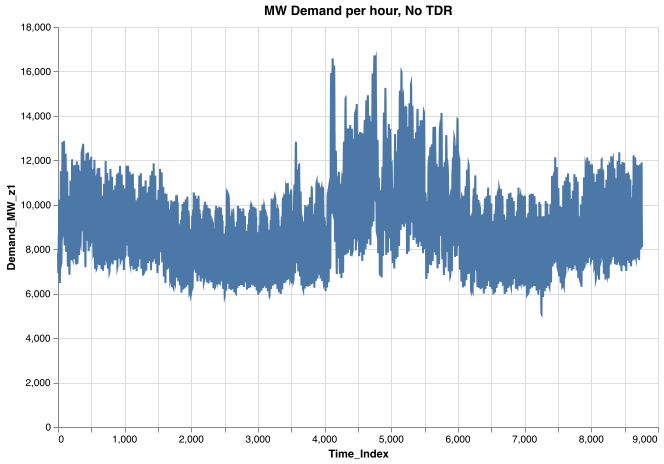

In [5]:
demand |>
@vlplot(:line, 
    x=:Time_Index, y=:Demand_MW_z1, title="MW Demand per hour, No TDR",
    width=600,height=400,linewidth=.01)

As in Tutorial 1, we can open the `genx_settings.yml` file for `1_three_zones` to see how `TimeDomainReduction` is set. If it's set to 1, this means TDR is being used.

In [6]:
genx_settings_TZ = YAML.load(open((joinpath(case,"settings/genx_settings.yml"))))

Dict{Any, Any} with 12 entries:
  "NetworkExpansion"       => 1
  "ParameterScale"         => 1
  "EnergyShareRequirement" => 0
  "TimeDomainReduction"    => 1
  "Trans_Loss_Segments"    => 1
  "CapacityReserveMargin"  => 0
  "StorageLosses"          => 1
  "UCommit"                => 2
  "MaxCapReq"              => 0
  "MinCapReq"              => 1
  "CO2Cap"                 => 2
  "WriteShadowPrices"      => 1

To visualize how TDR decreases computation time, let's start by running `example_systems/1_three_zones` without TDR. In the third section of this tutorial, we'll run the example again using TDR.

To run GenX without TDR, we start by editing the settings to set `TimeDomainReduction` to 0:

In [7]:
genx_settings_TZ["TimeDomainReduction"] = 0
genx_settings_TZ ## Output settings

Dict{Any, Any} with 12 entries:
  "NetworkExpansion"       => 1
  "ParameterScale"         => 1
  "EnergyShareRequirement" => 0
  "TimeDomainReduction"    => 0
  "Trans_Loss_Segments"    => 1
  "CapacityReserveMargin"  => 0
  "StorageLosses"          => 1
  "UCommit"                => 2
  "MaxCapReq"              => 0
  "MinCapReq"              => 1
  "CO2Cap"                 => 2
  "WriteShadowPrices"      => 1

Then we write the edited settings to the file path:

In [8]:
YAML.write_file((joinpath(case,"settings/genx_settings.yml")), genx_settings_TZ)

And run it using `include`. (Note: this process will take a few minutes):

In [9]:
@time include("example_systems/1_three_zones/Run.jl")

Configuring Settings
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum 

Writing Output
Time elapsed for writing costs is
1.434430209
Time elapsed for writing capacity is
0.354443833
Time elapsed for writing power is
0.716518459
Time elapsed for writing charge is
0.224961334
Time elapsed for writing capacity factor is
0.255860875
Time elapsed for writing storage is
0.149834375
Time elapsed for writing curtailment is
0.253050708
Time elapsed for writing nse is
0.616853792
Time elapsed for writing power balance is
0.437503166
Time elapsed for writing transmission flows is
0.108793416
Time elapsed for writing transmission losses is
0.17465075
Time elapsed for writing network expansion is
0.082062292
Time elapsed for writing emissions is
0.342571416
Time elapsed for writing reliability is
0.114715834
Time elapsed for writing storage duals is
0.395036375
Time elapsed for writing commitment is
0.126379209
Time elapsed for writing startup is
0.093246375
Time elapsed for writing shutdown is
0.059283708
Time elapsed for writing fuel consumption is
0.470515667
Time e

This took a little while to run, and would take even longer for larger systems. Let's see how we can get the run time down using Time Domain Reduction. The next sections go over how _k_-means clustering is used to perform TDR, and how to interpret the resulting files in GenX.

### _K_-means clustering <a id="Kmeans"></a>

To perform TDR, GenX uses ___K_-means clustering__. _K_-means is an optimization method that clusters data into several groups based on their proximity to "centers" determined by the algorithm. 

_K_-means finds a set number of groups such that the variance between the distance of each point in the group to the mean of the group is minimized. 

$$
\begin{align*}
\mathop{\arg \min}\limits_{\mathbf{S}} & \sum_{i = 1}^k \sum_{x \in S_i} ||x - \mu_i||^2 \\
\end{align*}
$$

Where $\mathbf{S} = \{S_1, ... , S_k\}$ are the clusters, with $x$ denoting the elements of the clusters, and $\mu_i$ the mean of each cluster, i.e. the mean of the distances from each point to the center of the cluster. By taking the argmin over $\mathbf{S}$, the points $x$ are clustered into groups where their distance to the center is the smallest. For more information on how _k_-means works, see the  <a href="https://en.wikipedia.org/wiki/K-means_clustering" target="_blank">Wikipedia</a>. 

GenX uses the package `Clustering.jl`, with documentation <a href="https://juliastats.org/Clustering.jl/dev/kmeans.html#K-means" target="_blank">here</a>. As an example, using the package `ScikitLearn.jl`, let's generate data that can cluster easily.

In [31]:
centers = 5
samples=50
X, y = make_blobs(n_samples=samples,centers=centers); # From scikit-learn
b = DataFrame(X,:auto)

50×2 DataFrame
 Row │ x1         x2         
     │ Float64    Float64    
─────┼───────────────────────
   1 │ -1.70397   -6.61907
   2 │ -5.96677    0.198586
   3 │  6.82568    6.32178
   4 │ -5.15778   -0.436021
   5 │  1.40464   -5.18148
   6 │  1.53943    1.77137
   7 │  6.40678    7.34182
   8 │ -0.446182  -5.60638
   9 │ -8.54404   -1.77021
  10 │  9.51587   -2.42076
  11 │  1.69867    2.63663
  ⋮  │     ⋮          ⋮
  41 │  8.43644   -1.16785
  42 │ -5.03074   -1.22067
  43 │ -7.10178    0.0295998
  44 │ -7.11348   -0.939029
  45 │  1.72413    3.59852
  46 │ -0.289441  -6.99452
  47 │ -5.46547   -1.9804
  48 │  6.51309    8.00149
  49 │  8.50166   -3.06433
  50 │  1.10318   -2.48182
              29 rows omitted

Note that clustering works for data without obvious groupings, but using blobs as an example makes _k_-means easier to visualize.

In [32]:
plotly()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,title="Before K-means Clustering")

Now we use the function `kmeans`, which is also used in `src/time_domain_reduction` in GenX.

In [33]:
R = kmeans(transpose(Matrix(b)),centers)

KmeansResult{Matrix{Float64}, Float64, Int64}([9.144768969383426 3.4146930421518262 … 1.735762840815245 -1.1379660820915174; -1.550421213518396 5.358549809453935 … -4.536483843076386 -6.680487850660782], [5, 3, 2, 3, 4, 2, 2, 5, 3, 1  …  1, 3, 3, 3, 2, 5, 3, 2, 1, 4], [0.3241295428078814, 2.179925102132515, 12.562649668103518, 2.5998291491008843, 0.5256663305927844, 16.384483910347043, 12.885912878302648, 1.6322740036150947, 4.137205365146556, 0.8952114580661714  …  0.6480924373765333, 2.5149045518647597, 1.5791943346606416, 0.28546683787655525, 5.955710928306502, 0.8186141656207724, 2.0446623656445695, 16.585204111061472, 2.7055219548549303, 4.621815537410043], [10, 20, 10, 5, 5], [10, 20, 10, 5, 5], 330.6438990871925, 3, true)

`kmeans` returns three outputs: assignments, centers, and counts. Assignments shows to which cluster each point belongs, centers shows where the center coordinates of each cluster are, and counts shows how many points belong to each cluster.

In [34]:
println("Assignments = ",R.assignments)
println("")
println("Counts = ",R.counts)
println("")
println("Centers:")
R.centers

Assignments = [5, 3, 2, 3, 4, 2, 2, 5, 3, 1, 2, 1, 5, 2, 1, 2, 2, 1, 2, 2, 5, 3, 2, 2, 4, 2, 4, 2, 2, 1, 1, 3, 2, 2, 4, 3, 2, 2, 1, 1, 1, 3, 3, 3, 2, 5, 3, 2, 1, 4]

Counts = [10, 20, 10, 5, 5]

Centers:


2×5 Matrix{Float64}:
  9.14477  3.41469  -6.61391   1.73576  -1.13797
 -1.55042  5.35855  -1.12849  -4.53648  -6.68049

In [35]:
plotly()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,marker_z=R.assignments,c=:lightrainbow,title="After K-means Clustering")

In GenX, the representative periods are the centers of the clusters, each representing one week of the year. In the above example that would mean there are 52 data points gathered into 11 clusters (to see this for yourself, change `make_blobs` above to have 52 data points and 11 clusters.)

### Results of Time Domain Reduction <a id="TDRResults"></a>

To visualize the results of TDR, we'll set TDR = 1 back in the `genx_settings.yml` file in `example_systems/1_three_zones/`:

In [10]:
genx_settings_TZ["TimeDomainReduction"] = 1;

In [11]:
genx_settings_TZ

Dict{Any, Any} with 12 entries:
  "NetworkExpansion"       => 1
  "ParameterScale"         => 1
  "EnergyShareRequirement" => 0
  "TimeDomainReduction"    => 1
  "Trans_Loss_Segments"    => 1
  "CapacityReserveMargin"  => 0
  "StorageLosses"          => 1
  "UCommit"                => 2
  "MaxCapReq"              => 0
  "MinCapReq"              => 1
  "CO2Cap"                 => 2
  "WriteShadowPrices"      => 1

In [12]:
YAML.write_file((joinpath(case,"settings/genx_settings.yml")), genx_settings_TZ)

And run GenX again with TDR:

In [13]:
@time include("example_systems/1_three_zones/Run.jl")

Configuring Settings
Time Series Data Already Clustered.
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module


[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
0.712163542
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115671 rows, 69510 cols, 429605 nonzeros
108252 rows, 62091 cols, 431147 nonzeros
Presolve : Reductions: rows 108252(-45146); columns 62091(-58048); elements 431147(-84359)
Solving the presolved LP
IPX model has 108252 rows, 62091 columns and 431147 nonzeros
Input
    Number of variables:                                62091
    Number of free variables:                           3696
    Number of constraints:                              108252


Time elapsed for writing costs is
0.11236975
Time elapsed for writing capacity is
0.004709625
Time elapsed for writing power is
0.030471084
Time elapsed for writing charge is
0.021415958
Time elapsed for writing capacity factor is
0.010086917
Time elapsed for writing storage is
0.011293083
Time elapsed for writing curtailment is
0.023053667
Time elapsed for writing nse is
0.279917458
Time elapsed for writing power balance is
0.060595417
Time elapsed for writing transmission flows is
0.007778292
Time elapsed for writing transmission losses is
0.030350333
Time elapsed for writing network expansion is
0.000460542
Time elapsed for writing emissions is
0.040893625
Time elapsed for writing reliability is
0.006805167
Time elapsed for writing storage duals is
0.009547666
Time elapsed for writing commitment is
0.006532375
Time elapsed for writing startup is
0.014018041
Time elapsed for writing shutdown is
0.013928875
Time elapsed for writing fuel consumption is
0.046512459
Time elapsed for writ

As you can see, this took a significantly shorter amount of time to run!

Csv files with the results of TDR are generated automatically in a folder called `TDR_results` found within the same folder containing the input csv files, in this case `example_systems/1_three_zones`. The csv files in this folder show the files used in `Run.jl` that have been pared down from the initial input files.

As an example, consider the input file `Fuels_data.csv`:

In [14]:
Fuels_original = CSV.read(joinpath(case,"system/Fuels_data.csv"),DataFrame,missingstring="NA")

8761×5 DataFrame
  Row │ Time_Index  CT_NG    ME_NG    MA_NG    None  
      │ Int64       Float64  Float64  Float64  Int64 
──────┼──────────────────────────────────────────────
    1 │          0  0.05306  0.05306  0.05306      0
    2 │          1  5.45     5.45     5.28         0
    3 │          2  5.45     5.45     5.28         0
    4 │          3  5.45     5.45     5.28         0
    5 │          4  5.45     5.45     5.28         0
    6 │          5  5.45     5.45     5.28         0
    7 │          6  5.45     5.45     5.28         0
    8 │          7  5.45     5.45     5.28         0
    9 │          8  5.45     5.45     5.28         0
   10 │          9  5.45     5.45     5.28         0
   11 │         10  5.45     5.45     5.28         0
  ⋮   │     ⋮          ⋮        ⋮        ⋮       ⋮
 8752 │       8751  3.78     3.78     4.28         0
 8753 │       8752  3.78     3.78     4.28         0
 8754 │       8753  3.78     3.78     4.28         0
 8755 │       8754  3.78     3.78     4.28         0
 8756 │       8755  3.78     3.78     4.28         0
 8757 │       8756  3.78     3.78     4.28         0
 8758 │       8757  3.78     3.78     4.28         0
 8759 │       8758  3.78     3.78     4.28         0
 8760 │       8759  3.78     3.78     4.28         0
 8761 │       8760  3.78     3.78     4.28         0
                                    8740 rows omitted

Compared to `TDR_results/Fuels_data.csv`:

In [15]:
Fuels_TDR = CSV.read(joinpath(case,"TDR_results/Fuels_data.csv"),DataFrame,missingstring="NA")

1849×5 DataFrame
  Row │ Time_Index  CT_NG    ME_NG    MA_NG    None    
      │ Int64       Float64  Float64  Float64  Float64 
──────┼────────────────────────────────────────────────
    1 │          0  0.05306  0.05306  0.05306      0.0
    2 │          1  5.45     5.45     5.28         0.0
    3 │          2  5.45     5.45     5.28         0.0
    4 │          3  5.45     5.45     5.28         0.0
    5 │          4  5.45     5.45     5.28         0.0
    6 │          5  5.45     5.45     5.28         0.0
    7 │          6  5.45     5.45     5.28         0.0
    8 │          7  5.45     5.45     5.28         0.0
    9 │          8  5.45     5.45     5.28         0.0
   10 │          9  5.45     5.45     5.28         0.0
   11 │         10  5.45     5.45     5.28         0.0
  ⋮   │     ⋮          ⋮        ⋮        ⋮        ⋮
 1840 │       1839  3.78     3.78     4.28         0.0
 1841 │       1840  3.78     3.78     4.28         0.0
 1842 │       1841  3.78     3.78     4.28         0.0
 1843 │       1842  3.78     3.78     4.28         0.0
 1844 │       1843  3.78     3.78     4.28         0.0
 1845 │       1844  3.78     3.78     4.28         0.0
 1846 │       1845  3.78     3.78     4.28         0.0
 1847 │       1846  3.78     3.78     4.28         0.0
 1848 │       1847  3.78     3.78     4.28         0.0
 1849 │       1848  3.78     3.78     4.28         0.0
                                      1828 rows omitted

As you can see, the original has all 8,760 hours, while the TDR version only has 1,848 hours.

Below is the demand file for TDR:

In [16]:
demand_TDR = CSV.read(joinpath(case,"TDR_results/Demand_data.csv"),DataFrame,missingstring="NA")

1848×12 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String7                            String7    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1.0                                1.0        ⋯
    2 │          2               0.9                                0.04
    3 │          3               0.55                               0.024
    4 │          4               0.2                                0.003
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 1839 │
 1840 │                                                                        ⋯
 1841 │
 1842 │
 1843 │
 1844 │                                                                        ⋯
 1845 │
 1846 │
 1847 │
 1848 │                                                                        ⋯
                                                 9 columns and 1827 rows omitted

The 1,848 hours are divided into 11 sections of 168 hours, with each section representing one week of the original data.  The number of hours per representative period is set in `time_domain_reduction_settings.yml`. Also specified in the file are the minimum and maximum number of clusters we would like to have (in this case 8 and 11). The _k_-means algorithm will then select the number of clusters that should be sufficient to capture the GenX model in fewer time steps (in this case 11).

Below, we create arrays out of the representative weeks and plot them on the same plot used in the beginning of this tutorial. The file `Period_map` shows which periods (weeks) are used in TDR and which time step corresponds to each period:

In [17]:
Period_map = CSV.read(joinpath(case,"TDR_Results/Period_map.csv"),DataFrame,missingstring="NA")

52×3 DataFrame
 Row │ Period_Index  Rep_Period  Rep_Period_Index 
     │ Int64         Int64       Int64            
─────┼────────────────────────────────────────────
   1 │            1           4                 1
   2 │            2           4                 1
   3 │            3           4                 1
   4 │            4           4                 1
   5 │            5           7                 2
   6 │            6           7                 2
   7 │            7           7                 2
   8 │            8          52                11
   9 │            9           7                 2
  10 │           10          12                 3
  11 │           11          12                 3
  ⋮  │      ⋮            ⋮              ⋮
  43 │           43          42                 9
  44 │           44          42                 9
  45 │           45          48                10
  46 │           46          48                10
  47 │           47          48                10
  48 │           48          48                10
  49 │           49          52                11
  50 │           50           7                 2
  51 │           51          52                11
  52 │           52          52                11
                                   31 rows omitted

Let's do some pre-processing to plot the data:

In [18]:
# Find array of unique representative periods
rep_periods = unique(Period_map[!,"Rep_Period"])

# Create an array of the time steps and MW values of each representative period
weeks_demand = []
for i in rep_periods
    week_temp_demand = [repeat([i],168) demand[(168*i-167):168*i,"Time_Index"] demand[(168*i-167):168*i,"Demand_MW_z1"]]
    weeks_demand = [weeks_demand; week_temp_demand]
end

# Combine with Total (pre TDR)
demand_plot = [repeat(["Total"],8760) demand[!,"Time_Index"] demand[!,"Demand_MW_z1"]];

# Add column names and convert column type
demand_with_TDR = [demand_plot; weeks_demand]
demand_with_TDR = DataFrame(demand_with_TDR ,["Week","hour", "MW"])
demand_with_TDR[!,:hour] = convert.(Int64,demand_with_TDR[!,:hour]);
demand_with_TDR[!,:MW] = convert.(Float64,demand_with_TDR[!,:MW]);

Here's the same plot from before but with representative weeks highlighted:

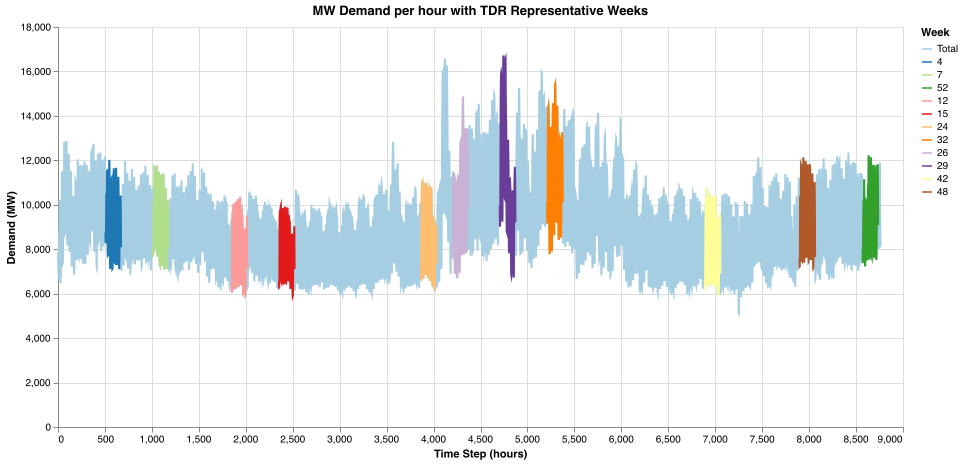

In [19]:
demand_with_TDR  |>
@vlplot(mark={:line},
    x={:hour,title="Time Step (hours)",labels="Week:n"}, y={:MW,title="Demand (MW)"},
    color={"Week:n", scale={scheme="paired"},sort="decsending"}, title="MW Demand per hour with TDR Representative Weeks",
    width=845,height=400)

TDR is performed for four total data sets: demand (found in `Demand_data.csv`), wind and solar (found in `Generators_variability.csv`), and fuel prices (found in `Fuels.csv`). Above is just the demand load for one of the three total nodes in the example system, which is why the data may not appear to "represent" all 52 weeks (notice there are fewer representative periods in the fall). Instead, the periods more accurately represent all the data time series combined, including some other parts of the data not seen in this particular plot.

### Extreme Periods Off <a id="ExtPeriods"></a>

GenX has a feature called `ExtremePeriods`, which forces _k_-means to include the highest and lowest points in the algorithm. This is done to ensure outliers are used, which is needed in planning energy capacity as the system needs to be able to account for outliers in energy needs. In the load demand plot above, we can see that energy needs peak during the summer, and that the week with the highest load demand is included as a representative week. Let's try turning extreme periods off, and see what happens.

In [20]:
time_domain_reduction_settings["ExtremePeriods"] = 0;
YAML.write_file(joinpath(case,"settings/time_domain_reduction_settings.yml"), time_domain_reduction_settings);
rm(joinpath(case,"TDR_results"), recursive=true) 

include("example_systems/1_three_zones/Run.jl")

Configuring Settings
Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
0.543359917
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115668 rows, 69478 cols, 429509 nonzeros
108249 rows, 62059 cols, 431051 nonzeros
Presolve : Reductions: rows 108249(-45149); columns 62059(-58080); elements 431051(-84452)
Solving the presolved LP
IPX model has 108249 rows, 62059 columns and 431051 nonzeros
Input
    Number of variables:                                62059
    Number of free variables:                           3696
    Number of constraints:                              108249
    Number of equality constraints:                     16605
 

Time elapsed for writing costs is
0.118218667
Time elapsed for writing capacity is
0.003000917
Time elapsed for writing power is
0.027590792
Time elapsed for writing charge is
0.018680959
Time elapsed for writing capacity factor is
0.010684875
Time elapsed for writing storage is
0.3641615
Time elapsed for writing curtailment is
0.021456625
Time elapsed for writing nse is
0.046203708
Time elapsed for writing power balance is
0.047207708
Time elapsed for writing transmission flows is
0.006458625
Time elapsed for writing transmission losses is
0.015552542
Time elapsed for writing network expansion is
0.000213417
Time elapsed for writing emissions is
0.021869917
Time elapsed for writing reliability is
0.007696209
Time elapsed for writing storage duals is
0.009616583
Time elapsed for writing commitment is
0.007460458
Time elapsed for writing startup is
0.017456917
Time elapsed for writing shutdown is
0.018367791
Time elapsed for writing fuel consumption is
0.057873458
Time elapsed for writi

In [23]:
Demand_TDR2 = CSV.read(joinpath(case,"TDR_results/Demand_data.csv"),DataFrame,missingstring="NA");
Period_map2 = CSV.read(joinpath(case,"TDR_results/Period_map.csv"),DataFrame,missingstring="NA")

52×3 DataFrame
 Row │ Period_Index  Rep_Period  Rep_Period_Index 
     │ Int64         Int64       Int64            
─────┼────────────────────────────────────────────
   1 │            1           4                 1
   2 │            2           4                 1
   3 │            3           4                 1
   4 │            4           4                 1
   5 │            5           8                 3
   6 │            6           7                 2
   7 │            7           7                 2
   8 │            8           8                 3
   9 │            9           7                 2
  10 │           10          12                 4
  11 │           11          12                 4
  ⋮  │      ⋮            ⋮              ⋮
  43 │           43          23                 7
  44 │           44          17                 5
  45 │           45          48                10
  46 │           46          48                10
  47 │           47          48                10
  48 │           48          48                10
  49 │           49          49                11
  50 │           50          49                11
  51 │           51           7                 2
  52 │           52           8                 3
                                   31 rows omitted

In [24]:
rep_periods2 = unique(Period_map2[!,"Rep_Period"])

weeks2 = []
for i in rep_periods2
    week_temp = [repeat([i],168) demand[(168*i-167):168*i,"Time_Index"] demand[(168*i-167):168*i,"Demand_MW_z1"]]
    weeks2 = [weeks2; week_temp]
end

weeks2 = [weeks2 repeat(["Off"],1848)];

demand_plotOff = [repeat(["Total"],8760) demand[!,"Time_Index"] demand[!,"Demand_MW_z1"] repeat(["Off"],8760) ];
demand_with_TDR[!,"Extreme_Periods"] = repeat(["On"],length(demand_with_TDR[!,1]));
demand_with_TDR2 = [demand_plotOff; weeks2]

demand_with_TDR2 = DataFrame(demand_with_TDR2 ,["Week","hour","MW","Extreme_Periods"])
demand_with_TDR2[!,:hour] = convert.(Int64,demand_with_TDR2[!,:hour]);
demand_with_TDR2[!,:MW] = convert.(Float64,demand_with_TDR2[!,:MW]);

# Define a new color scheme to accomodate more periods
myscheme = ["#a6cee3","#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f","#ff7f00",
    "#cab2d6","#6a3d9a","#ffff99","#b15928","#b1ff00","#095768","#ce7e00","#b4a7d6"];

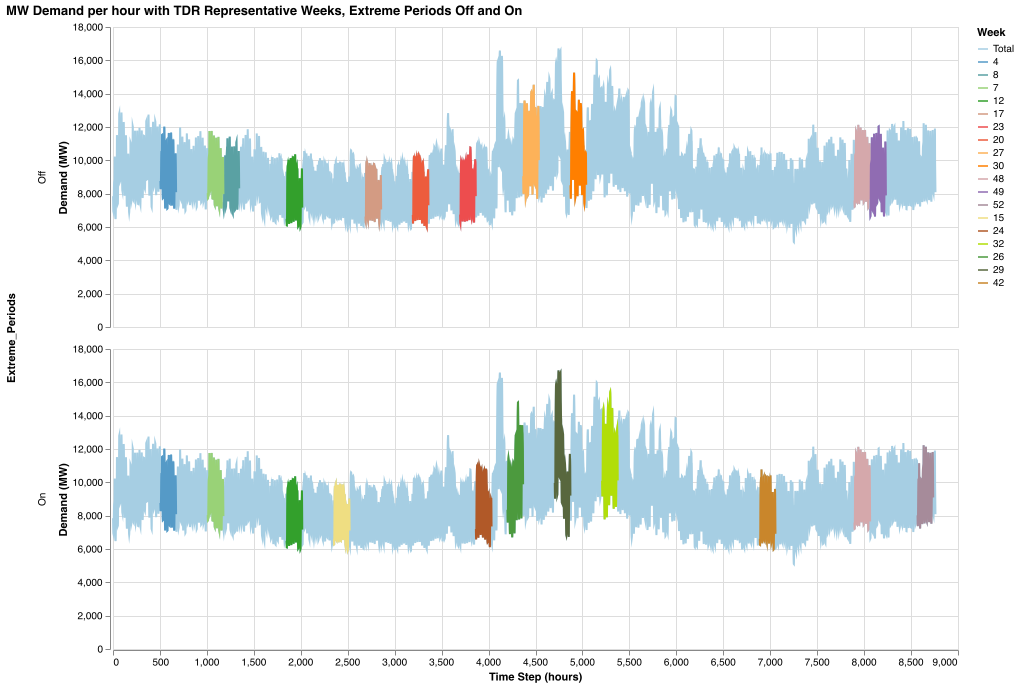

In [25]:
[demand_with_TDR2; demand_with_TDR] |>
@vlplot(mark={:line}, row="Extreme_Periods:n",
    x={:hour,title="Time Step (hours)",labels="Week:n"}, y={:MW,title="Demand (MW)"},
    color={"Week:n", scale={scheme=myscheme},sort="decsending"}, 
    title="MW Demand per hour with TDR Representative Weeks, Extreme Periods Off and On",
    width=845,height=300)

The first plot (with Extreme Periods off) may have the week with the highest peak highlighted. If the week with the highest demand is highlighted, try re-running the cell with Extreme Periods Off and plotting the results. However, it should always be the case that the second plot (Extreme Periods On) has the highest peak highlighted.

Turn Extreme Periods back on for future runs:

In [26]:
time_domain_reduction_settings["ExtremePeriods"] = 1;
YAML.write_file(joinpath(case,"settings/time_domain_reduction_settings.yml"), time_domain_reduction_settings);
rm(joinpath(case,"TDR_results"), recursive=true) 

### Reconstruction <a id="Reconstruction"></a>

Below is a plot of a reconstruction of the data using only the weeks isolated as representative periods. This is what GenX reads when it runs the solver with TDR on.



In [29]:
recon = []
recon_noex = []
for i in range(1,52)
    index = Period_map[i,"Rep_Period"]
    recon_temp = [repeat([index],168) collect((168*i-167):168*i) demand[(168*index-167):168*index,"Demand_MW_z1"]]
    recon = [recon; recon_temp]
    
    index2 = Period_map2[i,"Rep_Period"]
    recon_noex_temp = [repeat([index2],168) collect((168*i-167):168*i) demand[(168*index2-167):168*index2,"Demand_MW_z1"]]
    recon_noex = [recon_noex; recon_noex_temp]
end

recon = DataFrame(recon,["Week","hour", "MW"])
recon[!,:hour] = convert.(Int64,recon[!,:hour]);
recon[!,:MW] = convert.(Float64,recon[!,:MW]);
recon[!,"Extreme_Periods"] = repeat(["On"],length(recon[!,1]));

recon_noex = [recon_noex repeat(["Off"],8736)];
recon_noex = DataFrame(recon_noex,["Week","hour", "MW", "Extreme_Periods"])
recon_noex[!,:hour] = convert.(Int64,recon_noex[!,:hour]);
recon_noex[!,:MW] = convert.(Float64,recon_noex[!,:MW]);

Each color represents one of the representative weeks.

The range of 8-11 representative periods was chosen by the developers because it was deemed to be the smallest set that still matches the optimal value of the data well. The next section of this Tutorial goes over how the optimal values of the data change as the number of representative periods changes.

### Objective Values and Representative Periods <a id="ObjVals"></a>

Each time `Run.jl` is run, a `results` folder is produced. This folder contains numerous csv files with output variable from the GenX model. For more information on all outputs, see the documentation <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/model_output/" target="_blank">here</a>.

This section focuses on the __objective value__ of the model. In optimization problems, the objective value is the main value minimized or maximized within the constraints of the model, according to the __objective function__ specified in the problem formulation. In the case of GenX, the objective function is the total annual electricity system cost. A detailed description of the optimization problem is  <a href="https://genxproject.github.io/GenX.jl/dev/Model_Concept_Overview/objective_function/" target="_blank">here</a> in the documentation. 

For the purpose of this tutorial, we focus on the objective value as a way to evaluate how well the representative periods actually "represent" the entire model. To see how well the objective value of representative periods aligns with that of the total period, we can run `example_systems/1_three_zone` with a variety of minimum and maximum total periods.

As a reminder, here are the time domain reduction settings we've been using:

In [36]:
time_domain_reduction_settings

Dict{Any, Any} with 15 entries:
  "IterativelyAddPeriods" => 1
  "ExtremePeriods"        => 1
  "UseExtremePeriods"     => 1
  "MinPeriods"            => 8
  "MaxPeriods"            => 11
  "DemandWeight"          => 1
  "ClusterFuelPrices"     => 1
  "nReps"                 => 100
  "MultiStageConcatenate" => 0
  "Threshold"             => 0.05
  "TimestepsPerRepPeriod" => 168
  "IterateMethod"         => "cluster"
  "ScalingMethod"         => "S"
  "ClusterMethod"         => "kmeans"
  "WeightTotal"           => 8760

Each time Run.jl is run, a new results folder appears in the model folder. These folders are __not__ overwritten. So far, we've run the model three times, so we should have three results folders in the `1_three_zones` folder, but you may have more if you've run the model more. To ensure that the following code works, we'll delete any results folders beyond the original.

In [37]:
print(pwd())

/Users/mayamutic/Desktop/GenX-Tutorials/Tutorials

In [38]:
folders = cd(readdir,case)

15-element Vector{String}:
 ".DS_Store"
 "README.md"
 "Run.jl"
 "policies"
 "resources"
 "results"
 "results_1"
 "results_2"
 "results_3"
 "results_4"
 "results_5"
 "results_6"
 "results_7"
 "settings"
 "system"

In [39]:
for folder in folders
    if length(folder) >= 8 && folder[1:8] == "results_"
        rm("example_systems/1_three_zones/" * folder,recursive=true) 
    end
end
     
cd(readdir,case) ## Make sure they were deleted

8-element Vector{String}:
 ".DS_Store"
 "README.md"
 "Run.jl"
 "policies"
 "resources"
 "results"
 "settings"
 "system"

To demonstrate how the objective value changes as the number of representative periods does, we'll run GenX ten times, each with a different number of periods, and plot the objective values.

In [40]:
# Change MinPeriods and Max Periods, run `Run.jl`
# For simplicity, keep min and max periods the same
rep_periods = [4, 8, 12, 24, 36, 48]
times = [0.0,0.0,0.0,0.0,0.0,0.0]

for i in range(1,6)
    println(" ")
    println("----------------------------------------------------")
    println("Iteration ",i)
    println("Periods = ",rep_periods[i])
    println("----------------------------------------------------")
    time_domain_reduction_settings["MinPeriods"] = rep_periods[i]
    time_domain_reduction_settings["MaxPeriods"] = rep_periods[i]
    if "TDR_results" in cd(readdir,case)
        rm(joinpath(case,"TDR_results"), recursive=true) 
    end
    println(" ")
    YAML.write_file(joinpath(case,"settings/time_domain_reduction_settings.yml"), time_domain_reduction_settings)
    time = @elapsed include("example_systems/1_three_zones/Run.jl")
    times[i] = time
    println(" ")
    println("Total Elapsed Time: ", time, " seconds")
end

    

 
----------------------------------------------------
Iteration 1
Periods = 4
----------------------------------------------------
 
Configuring Settings
Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Error: Geography Key 1 is invalid. Select `System' or `Zone'.
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 1

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
1.555070042
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
42084 rows, 25309 cols, 156297 nonzeros
39497 rows, 22722 cols, 156445 nonzeros
Presolve : Reductions: rows 39497(-16293); columns 22722(-20977); elements 156445(-31023)
Solving the presolved LP
IPX model has 39497 rows, 22722 columns and 156445 nonzeros
Input
    Number of variables:                                22722
    Number of free variables:                           1344
    Number of constraints

Time elapsed for writing storage is
0.035797709
Time elapsed for writing curtailment is
0.012580167
Time elapsed for writing nse is
0.022850167
Time elapsed for writing power balance is
0.021459833
Time elapsed for writing transmission flows is
0.0018825
Time elapsed for writing transmission losses is
0.005310291
Time elapsed for writing network expansion is
0.00551475
Time elapsed for writing emissions is
0.016645417
Time elapsed for writing reliability is
0.002415125
Time elapsed for writing storage duals is
0.008327167
Time elapsed for writing commitment is
0.002206125
Time elapsed for writing startup is
0.004929583
Time elapsed for writing shutdown is
0.004779291
Time elapsed for writing fuel consumption is
0.028099459
Time elapsed for writing co2 is
0.012452625
Time elapsed for writing price is
0.002409375
Time elapsed for writing energy revenue is
0.009714542
Time elapsed for writing charging cost is
0.002198583
Time elapsed for writing subsidy is
0.015753458
Time elapsed for wri

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
0.3544195
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
84048 rows, 50453 cols, 312103 nonzeros
77640 rows, 44045 cols, 317281 nonzeros
Presolve : Reductions: rows 77640(-33926); columns 44045(-43334); elements 317281(-57589)
Solving the presolved LP
IPX model has 77640 rows, 44045 columns and 317281 nonzeros
Input
    Number of variables:                                44045
    Number of free variables:                           2688
    Number of constraints:                              77640
    Number of equality constraints:                     11064
    Numb

Time elapsed for writing costs is
0.114215083
Time elapsed for writing capacity is
0.007133042
Time elapsed for writing power is
0.022452333
Time elapsed for writing charge is
0.016685625
Time elapsed for writing capacity factor is
0.008221375
Time elapsed for writing storage is
0.010700208
Time elapsed for writing curtailment is
0.02218825
Time elapsed for writing nse is
0.04095875
Time elapsed for writing power balance is
0.0510995
Time elapsed for writing transmission flows is
0.004636125
Time elapsed for writing transmission losses is
0.011627291
Time elapsed for writing network expansion is
0.000332875
Time elapsed for writing emissions is
0.017942791
Time elapsed for writing reliability is
0.005232833
Time elapsed for writing storage duals is
0.011515875
Time elapsed for writing commitment is
0.007005333
Time elapsed for writing startup is
0.011706458
Time elapsed for writing shutdown is
0.010323833
Time elapsed for writing fuel consumption is
0.411141833
Time elapsed for writing

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
0.586374625
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
126169 rows, 75808 cols, 468605 nonzeros
118197 rows, 67836 cols, 469821 nonzeros
Presolve : Reductions: rows 118197(-49145); columns 67836(-63223); elements 469821(-92525)
Solving the presolved LP
IPX model has 118197 rows, 67836 columns and 469821 nonzeros
Input
    Number of variables:                                67836
    Number of free variables:                           4032
    Number of constraints:                              118197


Time elapsed for writing costs is
0.157482084
Time elapsed for writing capacity is
0.005514833
Time elapsed for writing power is
0.041480708
Time elapsed for writing charge is
0.021536292
Time elapsed for writing capacity factor is
0.012501416
Time elapsed for writing storage is
0.016682541
Time elapsed for writing curtailment is
0.027428375
Time elapsed for writing nse is
0.353300875
Time elapsed for writing power balance is
0.051377667
Time elapsed for writing transmission flows is
0.005663709
Time elapsed for writing transmission losses is
0.015412042
Time elapsed for writing network expansion is
0.00032075
Time elapsed for writing emissions is
0.023529125
Time elapsed for writing reliability is
0.006687917
Time elapsed for writing storage duals is
0.009959709
Time elapsed for writing commitment is
0.0074385
Time elapsed for writing startup is
0.014556292
Time elapsed for writing shutdown is
0.014388042
Time elapsed for writing fuel consumption is
0.050325
Time elapsed for writing c

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Error: Geography Key 1 is invalid. Select `System' or `Zone'.
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capa

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
1.308979833
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
252240 rows, 151488 cols, 936854 nonzeros
237030 rows, 136278 cols, 936338 nonzeros
Presolve : Reductions: rows 237030(-97640); columns 136278(-125821); elements 936338(-188246)
Solving the presolved LP
IPX model has 237030 rows, 136278 columns and 936338 nonzeros
Input
    Number of variables:                                136278
    Number of free variables:                           8064
    Number of constraints:                              

Writing Output
Time elapsed for writing costs is
0.650374125
Time elapsed for writing capacity is
0.002584958
Time elapsed for writing power is
0.057717083
Time elapsed for writing charge is
0.03624425
Time elapsed for writing capacity factor is
0.020465333
Time elapsed for writing storage is
0.021032
Time elapsed for writing curtailment is
0.048824375
Time elapsed for writing nse is
0.118141833
Time elapsed for writing power balance is
0.161111417
Time elapsed for writing transmission flows is
0.016687584
Time elapsed for writing transmission losses is
0.032612875
Time elapsed for writing network expansion is
0.000327417
Time elapsed for writing emissions is
0.051541875
Time elapsed for writing reliability is
0.018423167
Time elapsed for writing storage duals is
0.021278209
Time elapsed for writing commitment is
0.013644333
Time elapsed for writing startup is
0.033271542
Time elapsed for writing shutdown is
0.027514917
Time elapsed for writing fuel consumption is
0.093867875
Time elap

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
2.032884625
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
378335 rows, 227211 cols, 1405179 nonzeros
355542 rows, 204418 cols, 1404305 nonzeros
Presolve : Reductions: rows 355542(-146456); columns 204418(-188721); elements 1404305(-282594)
Solving the presolved LP
IPX model has 355542 rows, 204418 columns and 1404305 nonzeros
Input
    Number of variables:                                204418
    Number of free variables:                           12096
    Number of constraints:                        

Writing Output
Time elapsed for writing costs is
0.806483666
Time elapsed for writing capacity is
0.007582958
Time elapsed for writing power is
0.091572625
Time elapsed for writing charge is
0.056525958
Time elapsed for writing capacity factor is
0.041149709
Time elapsed for writing storage is
0.038836083
Time elapsed for writing curtailment is
0.120793083
Time elapsed for writing nse is
0.16693625
Time elapsed for writing power balance is
0.17182375
Time elapsed for writing transmission flows is
0.016890209
Time elapsed for writing transmission losses is
0.082543416
Time elapsed for writing network expansion is
0.000511875
Time elapsed for writing emissions is
0.08205125
Time elapsed for writing reliability is
0.022943625
Time elapsed for writing storage duals is
0.029073959
Time elapsed for writing commitment is
0.019379042
Time elapsed for writing startup is
0.040684416
Time elapsed for writing shutdown is
0.040722334
Time elapsed for writing fuel consumption is
0.188375916
Time ela

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX-Tutorials/Tutorials/example_systems/1_three_zones
Generating the Optimization Model
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Time elapsed for model building is
2.650694833
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
504469 rows, 302969 cols, 1873593 nonzeros
474065 rows, 272565 cols, 1872495 nonzeros
Presolve : Reductions: rows 474065(-195261); columns 272565(-251614); elements 1872495(-376774)
Solving the presolved LP
IPX model has 474065 rows, 272565 columns and 1872495 nonzeros
Input
    Number of variables:                                272565
    Number of free variables:                           16128
    Number of constraints

Writing Output
Time elapsed for writing costs is
1.007931459
Time elapsed for writing capacity is
0.008849917
Time elapsed for writing power is
0.125529083
Time elapsed for writing charge is
0.086364041
Time elapsed for writing capacity factor is
0.058719166
Time elapsed for writing storage is
0.101513375
Time elapsed for writing curtailment is
0.115550666
Time elapsed for writing nse is
0.299156916
Time elapsed for writing power balance is
0.371020125
Time elapsed for writing transmission flows is
0.03486125
Time elapsed for writing transmission losses is
0.099415417
Time elapsed for writing network expansion is
0.001198584
Time elapsed for writing emissions is
0.152400125
Time elapsed for writing reliability is
0.037120625
Time elapsed for writing storage duals is
0.057781667
Time elapsed for writing commitment is
0.080772291
Time elapsed for writing startup is
0.082531625
Time elapsed for writing shutdown is
0.074932792
Time elapsed for writing fuel consumption is
0.249656875
Time e

Note that as the number of periods increases, so does the time it takes to run.

Now, let's check that we have the correct Results folders and process the objecive values to plot. There should be seven results folders, including the original `results`.

The objective value is found in the files `costs.csv` and `status.csv`.

In [41]:
status = CSV.read(joinpath(case,"results/status.csv"),DataFrame,missingstring="NA")

1×3 DataFrame
 Row │ Status   Solve    Objval  
     │ String7  Float64  Float64 
─────┼───────────────────────────
   1 │ OPTIMAL  71351.7  9762.44

In [42]:
# Find objective values from each results folder:

OV_noTDR = CSV.read(joinpath(case,"results/status.csv"),DataFrame);
OV_RP4 = CSV.read(joinpath(case,"results_1/status.csv"),DataFrame);
OV_RP8 = CSV.read(joinpath(case,"results_2/status.csv"),DataFrame);
OV_RP12 = CSV.read(joinpath(case,"results_3/status.csv"),DataFrame);
OV_RP24 = CSV.read(joinpath(case,"results_4/status.csv"),DataFrame);
OV_RP36 = CSV.read(joinpath(case,"results_5/status.csv"),DataFrame);
OV_RP48 = CSV.read(joinpath(case,"results_6/status.csv"),DataFrame);

In [43]:
# Isolate the objective values from the data frame
obj_val_tot = [1 OV_noTDR[!,3]; 
               4 OV_RP4[!,3];
               8 OV_RP8[!,3];
               12 OV_RP12[!,3]; 
               24 OV_RP24[!,3]; 
               36 OV_RP36[!,3]; 
               48 OV_RP48[!,3]];
DataFrame(obj_val_tot,["Rep_Periods","Obj_Val"])

7×2 DataFrame
 Row │ Rep_Periods  Obj_Val  
     │ Float64      Float64  
─────┼───────────────────────
   1 │         1.0   9762.44
   2 │         4.0   8550.7
   3 │         8.0   9681.44
   4 │        12.0   9404.77
   5 │        24.0  10091.5
   6 │        36.0   9819.98
   7 │        48.0   9712.62

In [44]:
# Take the absolute difference between the original objective value and the new ones
obj_val_plot = [4 abs(OV_noTDR[!,3][1]-OV_RP4[!,3][1]); 
                8 abs(OV_noTDR[!,3][1]-OV_RP8[!,3][1]); 
                12 abs(OV_noTDR[!,3][1]-OV_RP12[!,3][1]);
                24 abs(OV_noTDR[!,3][1]-OV_RP24[!,3][1]); 
                36 abs(OV_noTDR[!,3][1]-OV_RP36[!,3][1]); 
                48 abs(OV_noTDR[!,3][1]-OV_RP48[!,3][1])]
DataFrame(obj_val_plot,["Rep_Periods","Error"])

6×2 DataFrame
 Row │ Rep_Periods  Error     
     │ Float64      Float64   
─────┼────────────────────────
   1 │         4.0  1211.74
   2 │         8.0    80.9956
   3 │        12.0   357.663
   4 │        24.0   329.095
   5 │        36.0    57.5463
   6 │        48.0    49.8125

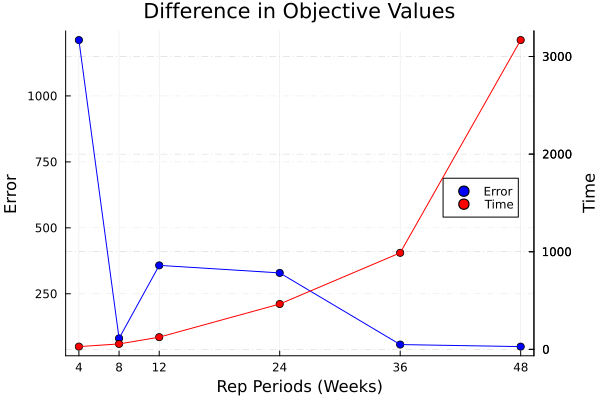

In [45]:
# Plot the differences as a function of number of representative periods
gr()
Plots.scatter(obj_val_plot[:,1],obj_val_plot[:,2],xticks=obj_val_plot[:,1],color=:blue,
                ylabel="Error",xlabel="Rep Periods (Weeks)",title="Difference in Objective Values",label=:"Error")
scatter!(obj_val_plot[:,1],NaN.*times,color=:red,legend=:right,label="Time") # For the legend
plot!(obj_val_plot[:,1],obj_val_plot[:,2],xticks=obj_val_plot[:,1],label=false,color=:blue)
scatter!(twinx(),obj_val_plot[:,1],times,color=:red,legend=false,
    yaxis=(label="Time"),label="Time")
plot!(twinx(),obj_val_plot[:,1],times,color=:red,label=false)
ygrid!(:on, :dashdot, 0.1)

Here, we can see that while having very few representative periods produces an objective value that differs greatly from the orignal, once we reach around 12 representative periods the difference begins to taper out. Therefore, the original choice of 11 maximum periods in `1_three_zones` decreases the run time of GenX significantly while while maintaining an objective value close to the original. 

It's important to note, however, that  the difference does not always taper out, and for some systems you'll find that the error in objective value continues to decrease as the number of representative periods increases. There also is no way to know apriori what number of periods works.



Finally, let's set TDR to have 8 and 11 min/max periods again, and delete the TDR results folder for future runs.

In [46]:
time_domain_reduction_settings["MinPeriods"] = 8;
time_domain_reduction_settings["MaxPeriods"] = 11;

In [47]:
time_domain_reduction_settings

Dict{Any, Any} with 15 entries:
  "IterativelyAddPeriods" => 1
  "ExtremePeriods"        => 1
  "UseExtremePeriods"     => 1
  "MinPeriods"            => 8
  "MaxPeriods"            => 11
  "DemandWeight"          => 1
  "ClusterFuelPrices"     => 1
  "nReps"                 => 100
  "MultiStageConcatenate" => 0
  "Threshold"             => 0.05
  "TimestepsPerRepPeriod" => 168
  "IterateMethod"         => "cluster"
  "ScalingMethod"         => "S"
  "ClusterMethod"         => "kmeans"
  "WeightTotal"           => 8760

In [48]:
rm(joinpath(case,"TDR_results"), recursive=true) 
YAML.write_file(joinpath(case,"settings/time_domain_reduction_settings.yml"), time_domain_reduction_settings)
folders = cd(readdir,case)
for folder in folders
    if length(folder) >= 7 && folder[1:7] == "results"
        rm("example_systems/1_three_zones/" * folder,recursive=true) 
    end
end